In [1]:
import sys
sys.path.append("..")

from configs.plot_config import apply_plot_settings
from configs.math_functions import F, gaussian
from configs.parameters import *
from configs.filenames import *

from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import os

C = float(os.getenv("C", C))
sig = float(os.getenv("sig", sig))
itr = int(os.getenv("itr", itr))

print(f"📢 Using parameters: C={C}, sig={sig}, itr={itr}, tau={tau}, dt={dt}")

📢 Using parameters: C=0.01, sig=0.1, itr=20000, tau=1, dt=0.005


In [2]:
output_dir = "../data/"

# Phase Length

✅ Opened ../data/WCM_GAUSSIAN_delay_itr=20000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_E0=0_I0=0.npy
The period T is: 7.1875


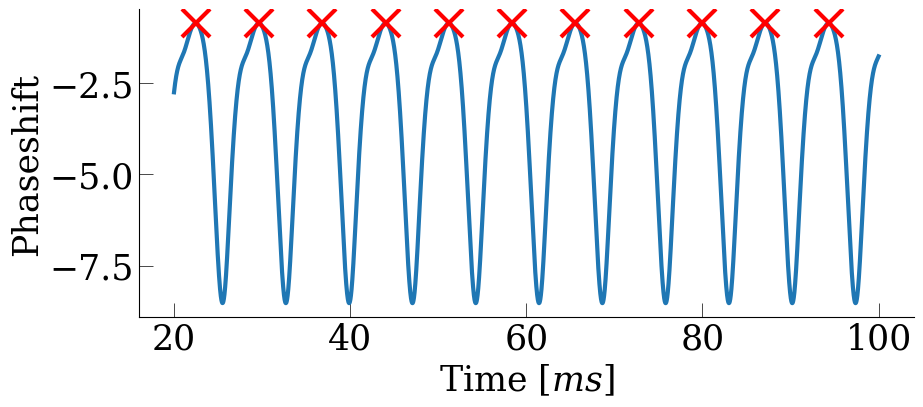

In [3]:
lower_bound = int(20/dt)
upper_bound = int(800/dt)

params   = get_params_for_filename(param_keys, globals())
filename = get_filename("gaussian", "WCM", **params)
savefile = os.path.join(output_dir, filename)
data     = np.load(savefile, allow_pickle=True)      
tt, synEE, synII, EE, II = data[lower_bound:upper_bound,0], data[lower_bound:upper_bound,1], data[lower_bound:upper_bound,2], data[lower_bound:upper_bound,3], data[lower_bound:upper_bound,4]
print(f"✅ Opened {savefile}")

peaks,_ = find_peaks(EE, height = -2.5)  ### finds all peaks higher than height = xxx

diff = np.zeros(len(peaks)-1)           ### makes list of zeros

for i in range(len(peaks)-1):
    diff[i] = peaks[i+1] - peaks[i]     ### calculates the difference of indices between two peaks
    
T = np.sum(diff) * dt / len(diff)       ### sums all differences up, multliplies by dt to set into timespace and 
print('The period T is:', T)            ### averages over the number of peaks

apply_plot_settings()

fig, ax = plt.subplots(figsize=(10, 4)) 

ax.plot(tt, EE, linewidth=3)
ax.plot(tt[peaks], EE[peaks], "x", ms=20, markeredgecolor='red', markeredgewidth=3)

ax.set_xlabel('Time $[ms]$')
ax.set_ylabel('Phaseshift')

plt.show()

# Interaction

$$ H(\phi) = \frac{C}{T} \int_0^T ds~~ Z(s) \cdot X_0(\phi+s) $$

In [4]:
params = get_params_for_filename(param_keys, globals())
filename = get_filename("gaussian", "WCM", **params)
savefile = os.path.join(output_dir, filename)
data = np.load(savefile, allow_pickle=True)      
tt, synEE, synII, EE, II = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
print(f"✅ Opened {savefile}")

params = get_params_for_filename(param_keys, globals())
filename = get_filename("gaussian", "Normalized_PRC", **params)
savefile = os.path.join(output_dir, filename)
data = np.load(savefile, allow_pickle=True)      
tnorm, ZE_normalized, ZI_normalized = data[:,0], data[:,1], data[:,2]
print(f"✅ Opened {savefile}")

✅ Opened ../data/WCM_GAUSSIAN_delay_itr=20000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_E0=0_I0=0.npy
✅ Opened ../data/Normalized_PRC_GAUSSIAN_delay_itr=20000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_ZE1=-5_ZI1=1.npy


In [5]:
Start_idx = len(tt)/3
Start = int(Start_idx)
Stop = int(Start_idx+(T/dt))

ZE_1 = ZE_normalized[Start:Stop]
ZI_1 = ZI_normalized[Start:Stop]
EE_1 = EE[Start:Stop]
II_1 = II[Start:Stop]
tt_1 = tt[Start:Stop]

#first_minimum_EE = int(np.where(ZE_1 ==  np.amin(ZE_1))[0])
first_minimum_EE = np.argmin(ZE_1)  # ✅ Correct and efficient

Minimum_EE = np.amin(ZE_1)
print('Idx of first minimum, EE:', first_minimum_EE, '\n Start idx', Start)

#first_minimum_II = int(np.where(ZI_1 ==  np.amin(ZI_1))[0])
first_minimum_II = np.argmin(ZI_1)  # ✅ Correct and efficient

Minimum_II = np.amin(ZI_1)
print('Idx of first minimum, II:', first_minimum_II, '\n Start idx', Start)

new_Start_EE = int(Start+first_minimum_EE)
one_period_EE = int(Start+first_minimum_EE+(T/dt))

new_Start_II = int(Start+first_minimum_II)
one_period_II = int(Start+first_minimum_II+(T/dt))

ZE = ZE_normalized[new_Start_EE:one_period_EE]
EE = EE[new_Start_EE:one_period_EE]
tE = tt[new_Start_EE:one_period_EE]
tE = tE-tE[0]

ZI = ZI_normalized[new_Start_II:one_period_II]
II = II[new_Start_II:one_period_II]
tI = tt[new_Start_II:one_period_II]
tI = tI-tI[0]

# Interaction Function
#######################

H_integral_EE = np.zeros(len(tE))

for i in range(len(tE)):
    H_integral_EE[i] = (C/T) * (np.sum(ZE * np.roll(EE,i)) * dt) 
    
H_odd_EE = -(H_integral_EE[::] - H_integral_EE[::-1])

H_integral_II = np.zeros(len(tI))

for i in range(len(tI)):
    H_integral_II[i] = (C/T) * (np.sum(ZI * np.roll(II,i)) * dt) 
    
H_odd_II = -(H_integral_II[::] - H_integral_II[::-1])

params = get_params_for_filename(param_keys, globals())
filename = get_filename("gaussian", "Interaction", **params)
savefile = os.path.join(output_dir, filename)

np.savez(
    savefile, 
    tt=tt, 
    H_odd_EE=H_odd_EE, 
    ZE=ZE, 
    tE=tE, 
    H_odd_II=H_odd_II, 
    ZI=ZI, 
    tI=tI, 
    T=T
)

print(f"Data saved successfully at {savefile}")

Idx of first minimum, EE: 531 
 Start idx 6667
Idx of first minimum, II: 1174 
 Start idx 6667
Data saved successfully at ../data/Interaction_Function_GAUSSIAN_delay_itr=20000_dt=0.005_tau=1_sig=0.1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_C=0.01.npz
